# Author: David Dukić

## Import libraries

In [1]:
import pandas as pd
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from cleantext import clean
from collections import defaultdict
from nltk.corpus import stopwords
from PIL import Image
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
theme_bw = "theme_bw.mplstyle"
plt.style.use(theme_bw)
plt.rcParams["figure.figsize"] = (15, 10)
%matplotlib inline

# import nltk
# nltk.download()

path = "../dataset/"

## Clean text function

In [2]:
def clean_text(text):
    return clean(
        text,
        fix_unicode=True,
        to_ascii=True,
        lower=True,
        no_line_breaks=False,
        no_punct=True,
        lang="en",
    )

## Read df

In [3]:
df = pd.read_csv(path + "train_clean.csv", sep=";")

## Select only the clean columns

In [4]:
df = df.drop(["tweet", "tweet_clean_extra"], axis=1)
df = df.rename(columns={"tweet_clean": "tweet"})

## Load stopwords and compile regex

In [5]:
with open("./english") as f:
    stopwords = [clean_text(line.strip()) for line in f.readlines()]
    stopwords.append("user")
    stopwords.append("rt")
    stopwords.append("hashtag")
    stopwords.append("url")
    comp_stop_start_match = re.compile("^" + "(" + "|".join(stopwords) + ")" + "\\b")
    comp_stop_end_match = re.compile("\\b(" + "|".join(stopwords) + ")" + "$")

# Help functions

In [6]:
def get_ngrams_for_text(min_ngram, max_ngram, text):
    vectorizer = CountVectorizer(ngram_range=(min_ngram, max_ngram))
    try:
        ngrams = vectorizer.fit_transform([text])
        vocabulary = vectorizer.vocabulary_
        counts = ngrams.toarray().sum(axis=0)
        freq_dict = {}
        for count, ngram in sorted(
            [(counts[i], k) for k, i in vocabulary.items()], reverse=True
        ):
            freq_dict[str(ngram)] = count
        return freq_dict
    except:
        pass


def merge_dicts(dicts_list):
    merged_dict = defaultdict(int)
    for d in dicts_list:
        if d:
            for key, value in d.items():
                merged_dict[key] += value
    return merged_dict


def remove_stop(ngrams):
    result_dict = defaultdict(int)
    if ngrams:
        for key, value in ngrams.items():
            while True:
                start_match = comp_stop_start_match.search(key)
                end_match = comp_stop_end_match.search(key)
                if not bool(start_match) and not bool(end_match):
                    break
                if bool(start_match):
                    key = " ".join(key.split()[1:])
                if bool(end_match):
                    key = " ".join(key.split()[:-1])
            if key:
                result_dict[key] += value
    return result_dict

## Create unigrams, bigrams and trigrams

In [7]:
df["ngrams"] = df.tweet.apply(lambda x: get_ngrams_for_text(1, 3, x))

## Remove stopwords from start and end

In [8]:
df["ngrams"] = df.ngrams.apply(remove_stop)

## Merge dicts with ngram counts

In [9]:
freq_dict_hate = merge_dicts(df[df.label == 1].ngrams.tolist())
freq_dict_no_hate = merge_dicts(df[df.label == 0].ngrams.tolist())

## Normalize freqs between ngrams

In [10]:
def normalize_ngram_freq(freq_dict, multiplier=100, max_words=200):
    prop = int(max_words / 3)

    unigrams = sorted(
        [(key, value) for key, value in freq_dict.items() if len(key.split()) == 1],
        key=lambda x: x[1],
        reverse=True,
    )[:prop]
    bigrams = sorted(
        [
            ("_".join(key.split()), value)
            for key, value in freq_dict.items()
            if len(key.split()) == 2
        ],
        key=lambda x: x[1],
        reverse=True,
    )[:prop]
    trigrams = sorted(
        [
            ("_".join(key.split()), value)
            for key, value in freq_dict.items()
            if len(key.split()) == 3
        ],
        key=lambda x: x[1],
        reverse=True,
    )[:prop]

    total_u_freq = sum(map(lambda x: x[1], unigrams))
    unigrams = [
        (key, int((value / total_u_freq) * multiplier)) for (key, value) in unigrams
    ]

    total_b_freq = sum(map(lambda x: x[1], bigrams))
    bigrams = [
        (key, int((value / total_b_freq) * multiplier)) for (key, value) in bigrams
    ]

    total_t_freq = sum(map(lambda x: x[1], trigrams))
    trigrams = [
        (key, int((value / total_t_freq) * multiplier)) for (key, value) in trigrams
    ]

    result_dict = dict(dict(unigrams), **dict(bigrams))
    result_dict.update(dict(trigrams))

    return result_dict

## Create wordcloud for users who share hate speech

In [11]:
result_dict_hate = normalize_ngram_freq(freq_dict_hate)

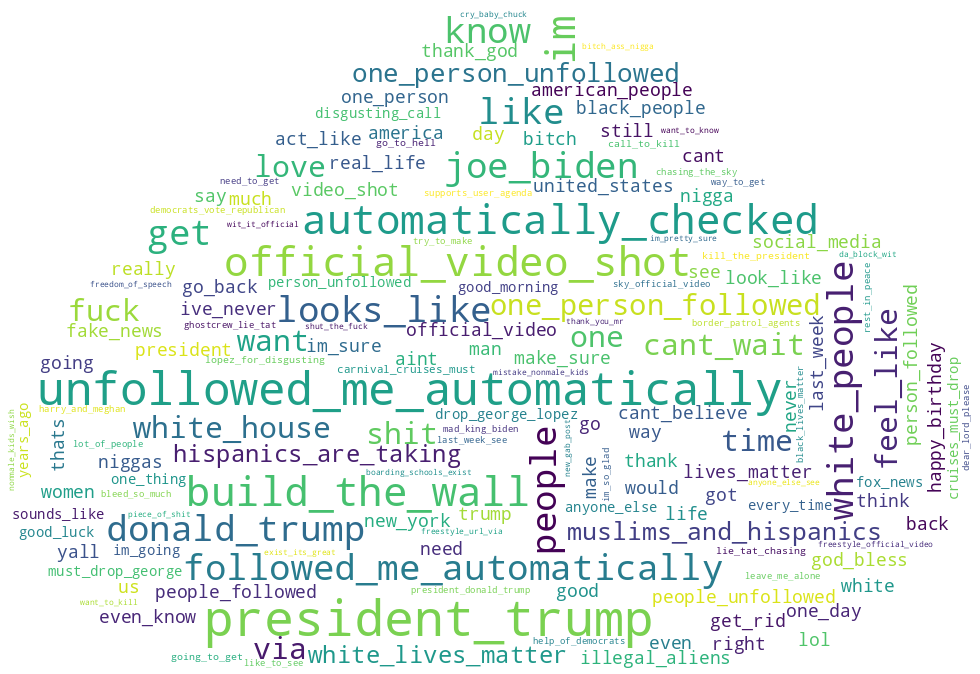

In [12]:
wordcloud = WordCloud(
    width=600,
    height=600,
    prefer_horizontal=0.9,
    background_color="white",
    mode="RGB",
    max_font_size=50,
    max_words=200,
    min_word_length=3,
    mask=np.array(Image.open("./cloud.png")),
).generate_from_frequencies(result_dict_hate)

wordcloud.to_image()

## Create wordcloud for users who do not share hate speech

In [13]:
result_dict_no_hate = normalize_ngram_freq(freq_dict_no_hate, multiplier=10000)

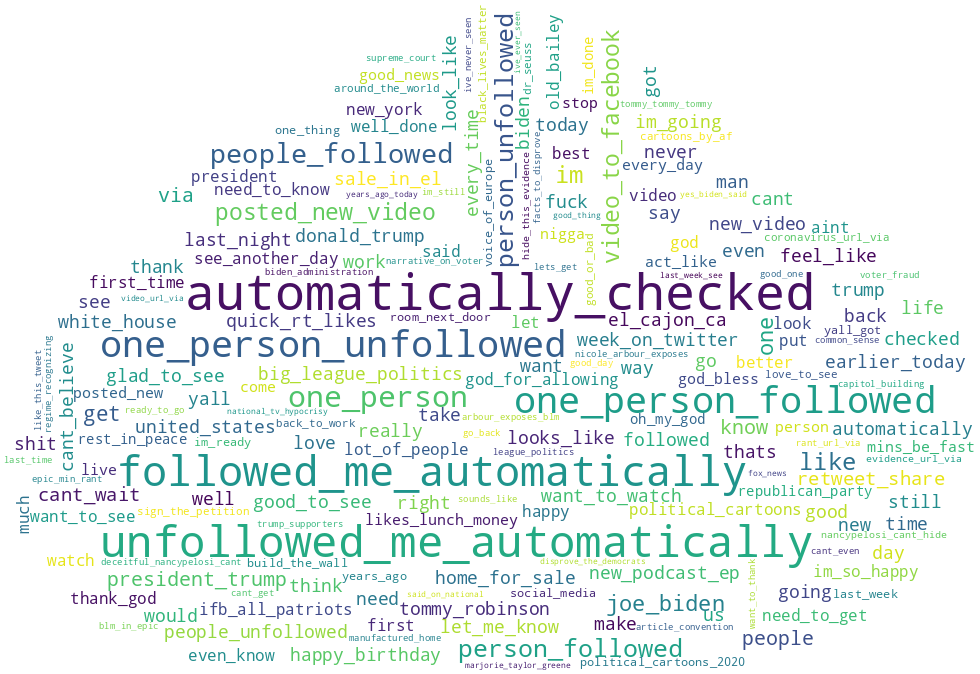

In [14]:
wordcloud = WordCloud(
    width=600,
    height=600,
    prefer_horizontal=0.9,
    background_color="white",
    mode="RGB",
    max_font_size=50,
    max_words=200,
    min_word_length=3,
    mask=np.array(Image.open("./cloud.png")),
).generate_from_frequencies(result_dict_no_hate)

wordcloud.to_image()

## Hashtag, mention, rt, url, emoji analysis

### Contingency table

In [15]:
df_indicators = df[["hashtag", "user", "rt", "url", "emoji", "label"]]
df_indicators["emoji"] = df_indicators.emoji.apply(lambda x: 0 if x != x else 1)

/home/ddukic/.conda/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
indicators_cont = df_indicators.groupby("label", group_keys=False).agg(
    {"hashtag": "sum", "user": "sum", "rt": "sum", "url": "sum", "emoji": "sum"}
)
indicators_cont

hashtag   user    rt   url  emoji
label                                   
0         1969  13335  7655  8304   4182
1         2126  13057  6097  6552   3659

In [17]:
chi2_contingency(indicators_cont)

(194.06813214501335,
 7.07974416029477e-41,
 4,
 array([[ 2168.44859269, 13975.50555755,  7282.17461456,  7866.78200072,
          4152.08923449],
        [ 1926.55140731, 12416.49444245,  6469.82538544,  6989.21799928,
          3688.91076551]]))

### MLE estimation with Laplacian smoothing

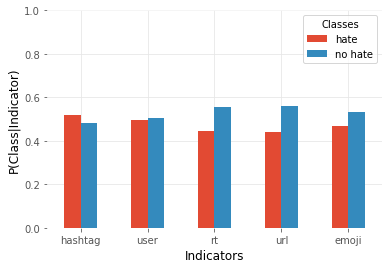

In [18]:
df_freq = (
    df_indicators.groupby("label", group_keys=False).size().reset_index(name="count")
)

indicators_list = ["hashtag", "user", "rt", "url", "emoji"]

N_indicators = [
    df_indicators[df_indicators[indicator] == 1][indicator].sum()
    for indicator in indicators_list
]

no_hate_data = indicators_cont.reset_index().iloc[0, range(1, 6)].tolist()
hate_data = indicators_cont.reset_index().iloc[1, range(1, 6)].tolist()

df_mle = pd.DataFrame(
    {
        "hate": [(m + 1) / (N + 2) for m, N in zip(hate_data, N_indicators)],
        "no hate": [(m + 1) / (N + 2) for m, N in zip(no_hate_data, N_indicators)],
    },
    index=indicators_list,
)

ax = df_mle.plot.bar(rot=0)
plt.ylim(0, 1)
plt.ylabel("P(Class|Indicator)")
plt.xlabel("Indicators")
plt.legend(title="Classes")
plt.savefig("../plots/mle_indicators.png", dpi=200)
plt.show()

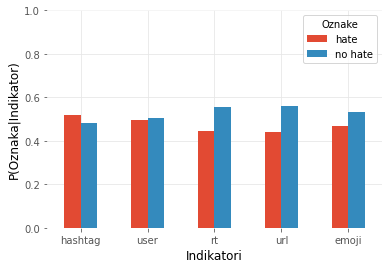

In [19]:
ax = df_mle.plot.bar(rot=0)
plt.ylim(0, 1)
plt.ylabel("P(Oznaka|Indikator)")
plt.xlabel("Indikatori")
plt.legend(title="Oznake")
plt.savefig("../plots/mle_indicators_hr.png", dpi=200)
plt.savefig("../plots/mle_indicators_hr_dira.png", dpi=1000)
plt.show()

## NLP wordcloud

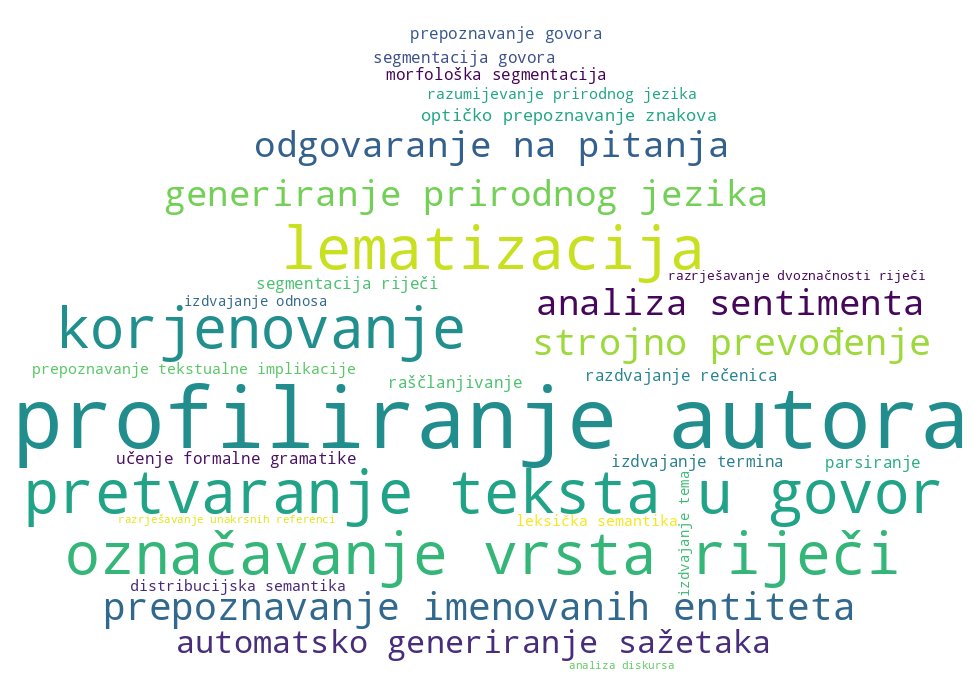

In [20]:
wordcloud = WordCloud(
    width=600,
    height=600,
    prefer_horizontal=0.7,
    background_color="white",
    mode="RGB",
    max_font_size=100,
    max_words=200,
    min_word_length=3,
    mask=np.array(Image.open("./cloud.png")),
).generate_from_frequencies({
    "optičko prepoznavanje znakova": 1,
    "prepoznavanje govora": 1,
    "segmentacija govora": 1,
    "pretvaranje teksta u govor": 10,
    "segmentacija riječi": 1,
    "lematizacija": 10,
    "morfološka segmentacija": 1,
    "označavanje vrsta riječi": 10,
    "parsiranje": 1,
    "razdvajanje rečenica": 1,
    "izdvajanje termina": 1,
    "korjenovanje": 10,
    "raščlanjivanje": 1,
    "prepoznavanje imenovanih entiteta": 10,
    "učenje formalne gramatike": 1,
    "leksička semantika": 1,
    "distribucijska semantika": 1,
    "strojno prevođenje": 10,
    "generiranje prirodnog jezika": 10,
    "razumijevanje prirodnog jezika": 1,
    "odgovaranje na pitanja": 10,
    "prepoznavanje tekstualne implikacije": 1,
    "izdvajanje odnosa": 1,
    "analiza sentimenta": 10,
    "izdvajanje tema": 1,
    "razrješavanje dvoznačnosti riječi": 1,
    "automatsko generiranje sažetaka": 10,
    "razrješavanje unakrsnih referenci": 1,
    "analiza diskursa": 1,
    "profiliranje autora": 20,
})

wordcloud.to_image()